In [ ]:
import scipy.sparse as sp
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve,auc,confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
from math import log
import numpy as np
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from prettytable import PrettyTable
from random import randrange 
from random import seed
from prettytable import PrettyTable

In [ ]:
loaded_train_features = sp.load_npz("train_features.npz")
loaded_test_features = sp.load_npz("test_features.npz")
print(loaded_train_features.shape)
print(loaded_test_features.shape)

(23165, 40029)
(7728, 40029)


In [ ]:
y_train = pd.read_pickle('/content/y_train_vals.pkl') 
y_test = pd.read_pickle('/content/y_test_vals.pkl')

In [ ]:
y_train.shape

(23165,)

In [ ]:
#Feature scaling
scale = StandardScaler(with_mean=False)
scaled_X_train = scale.fit_transform(loaded_train_features)
scaled_X_test = scale.transform(loaded_test_features)

In [ ]:
def calc_metrics(cm,ytest,ypred,probval):
    precision = cm[1][1]/(cm[1][1]+cm[0][1])
    recall    = cm[1][1]/(cm[1][1]+cm[1][0])
    f1_score  = (2*precision*recall)/(precision+recall)  
    acc       = accuracy_score(ytest,ypred)
    auc       = roc_auc_score(y_test,probval)
    return precision, recall, f1_score, acc, auc

#Random Model

In [ ]:
#https://machinelearningmastery.com/implement-baseline-machine-learning-algorithms-scratch-python/
# Generate random predictions
def random_algorithm(train, test):
    output_values = [row for row in train]
    unique = list(set(output_values))
    predicted = list()
    for row in test:
      index = randrange(len(unique))
      predicted.append(unique[index])
    return predicted

In [ ]:
seed(1)
predictions = random_algorithm(y_train, y_test)
print('F1-Score of Random Model ',f1_score(y_test,predictions))
print('Accuracy of Random Model ',accuracy_score(y_test,predictions))
print('AUC of Random Model       0.5')

F1-Score of Random Model  0.4294021171909945
Accuracy of Random Model  0.504787784679089
AUC of Random Model       0.5


#Logistic Regression

In [ ]:
lr_parameters = {'alpha':[10 ** x for x in range(-5, 5)]}
lr_clf = SGDClassifier(loss='log',class_weight='balanced',random_state=30)
lr_random = RandomizedSearchCV(lr_clf,param_distributions=lr_parameters,
                               scoring='roc_auc',n_jobs=-1,cv=5,
                               return_train_score=True)
lr_random.fit(scaled_X_train,y_train)
lr_probtest = lr_random.predict_proba(scaled_X_test)[:,1]
print("Best alpha :",lr_random.best_params_['alpha'])

Best alpha : 10


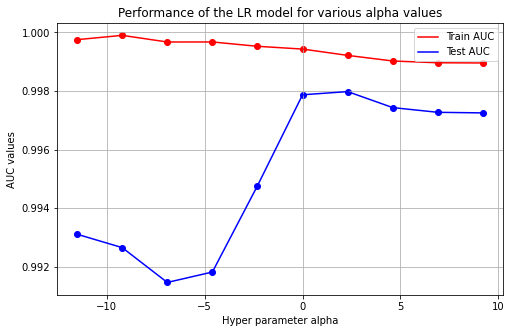

In [ ]:
plt.figure(figsize=(8,5))
lr_alpha=lr_random.cv_results_['param_alpha']
lr_train_auc = lr_random.cv_results_['mean_train_score']
lr_test_auc = lr_random.cv_results_['mean_test_score']
lr_log_alpha=[log(x) for x in lr_alpha]
plt.plot(lr_log_alpha, lr_train_auc,color='red',label='Train AUC')
plt.plot(lr_log_alpha, lr_test_auc, color='blue', label='Test AUC')
plt.scatter(lr_log_alpha, lr_train_auc,color='red')
plt.scatter(lr_log_alpha, lr_test_auc,color='blue')
plt.title("Performance of the LR model for various alpha values")
plt.xlabel("Hyper parameter alpha")
plt.ylabel("AUC values")
plt.legend()
plt.grid()
plt.show()

In [ ]:
lr_best_alpha = lr_random.best_params_['alpha']
lr_best_model = SGDClassifier(alpha=lr_best_alpha, loss='log',random_state=30)
lr_best_model.fit(scaled_X_train,y_train)

SGDClassifier(alpha=10, loss='log', random_state=30)

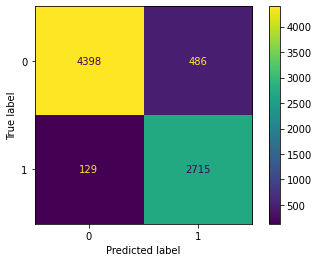

In [ ]:
lr_pred_best = lr_best_model.predict(scaled_X_test)
lr_cm=confusion_matrix(y_test,lr_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=lr_cm)
disp.plot()
plt.show()

In [ ]:
lr_precision, lr_recall, lr_f1_score, lr_accval, lr_aucval = calc_metrics(lr_cm,y_test,lr_pred_best,lr_probtest)
print('Precision :',round(lr_precision,5))
print('Recall    :',round(lr_recall,5))
print('F1-score  :',round(lr_f1_score,5))
print('Accuracy  :',round(lr_accval,5))
print('AUC       :',round(lr_aucval,5))

Precision : 0.84817
Recall    : 0.95464
F1-score  : 0.89826
Accuracy  : 0.92042
AUC       : 0.99777


#SVM

In [ ]:
svm_parameters = {'alpha':[10 ** x for x in range(-5, 5)]}
svm_clf = SGDClassifier(loss='hinge',class_weight='balanced',random_state=30)
svm_random = RandomizedSearchCV(svm_clf,param_distributions=svm_parameters,
                               scoring='roc_auc',n_jobs=-1,cv=5,
                               return_train_score=True)
svm_random.fit(scaled_X_train,y_train)
svm_calibrator = CalibratedClassifierCV(svm_random, method="sigmoid")
svm_model = svm_calibrator.fit(scaled_X_train, y_train)
svm_ytrain_pred = svm_model.predict_proba(scaled_X_train)[:,1]
svm_ytest_pred = svm_model.predict_proba(scaled_X_test)[:,1]
print("Best alpha :",svm_random.best_params_['alpha'])

Best alpha : 10


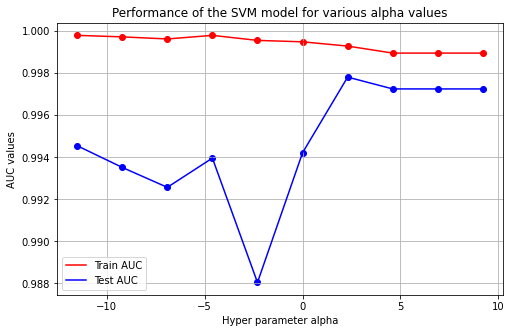

In [ ]:
plt.figure(figsize=(8,5))
svm_alpha = svm_random.cv_results_['param_alpha']
svm_train_auc = svm_random.cv_results_['mean_train_score']
svm_test_auc = svm_random.cv_results_['mean_test_score']
svm_log_alpha=[log(x) for x in svm_alpha]
plt.plot(svm_log_alpha, svm_train_auc,color='red',label='Train AUC')
plt.plot(svm_log_alpha, svm_test_auc, color='blue', label='Test AUC')
plt.scatter(svm_log_alpha, svm_train_auc,color='red')
plt.scatter(svm_log_alpha, svm_test_auc,color='blue')
plt.title("Performance of the SVM model for various alpha values")
plt.xlabel("Hyper parameter alpha")
plt.ylabel("AUC values")
plt.legend()
plt.grid()
plt.show()

In [ ]:
svm_best_alpha = svm_random.best_params_['alpha']
svm_best_model = SGDClassifier(alpha=svm_best_alpha, loss='hinge',random_state=30)
svm_best_model.fit(scaled_X_train,y_train)

SGDClassifier(alpha=10, random_state=30)

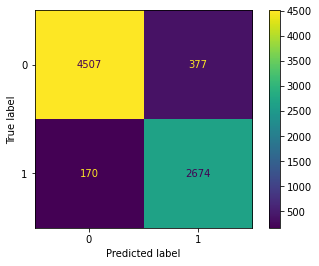

In [ ]:
svm_pred_best = svm_best_model.predict(scaled_X_test)
svm_cm = confusion_matrix(y_test,svm_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=svm_cm)
disp.plot()
plt.show()

In [ ]:
svm_precision, svm_recall, svm_f1_score, svm_accval, svm_aucval = calc_metrics(svm_cm,y_test,svm_pred_best,svm_ytest_pred)
print('Precision :',round(svm_precision,5))
print('Recall    :',round(svm_recall,5))
print('F1-score  :',round(svm_f1_score,5))
print('Accuracy  :',round(svm_accval,5))
print('AUC       :',round(svm_aucval,5))

Precision : 0.87643
Recall    : 0.94023
F1-score  : 0.90721
Accuracy  : 0.92922
AUC       : 0.99442


#Naive Bayes

In [ ]:
nb_parameters = {'alpha':[10 ** x for x in range(-5, 5)]}
nb_clf = MultinomialNB(class_prior=[0.5,0.5])
nb_random = RandomizedSearchCV(nb_clf,param_distributions=nb_parameters,
                               scoring='roc_auc',n_jobs=-1,cv=5,
                               return_train_score=True)
nb_random.fit(scaled_X_train,y_train)
nb_probtest = nb_random.predict_proba(scaled_X_test)[:,1]
print("Best alpha :",nb_random.best_params_['alpha'])

Best alpha : 10000


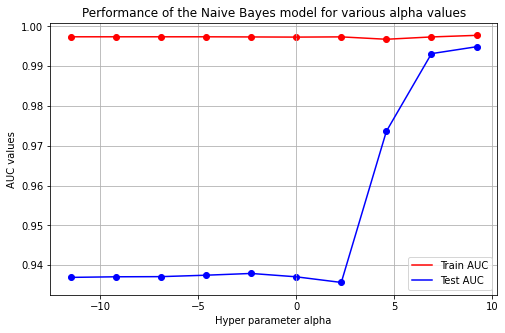

In [ ]:
#From Naive Bayes Assignment
plt.figure(figsize=(8,5))
nb_alpha=nb_random.cv_results_['param_alpha']
nb_train_auc = nb_random.cv_results_['mean_train_score']
nb_test_auc = nb_random.cv_results_['mean_test_score']
nb_log_alpha=[log(x) for x in nb_alpha]
plt.plot(nb_log_alpha, nb_train_auc,color='red',label='Train AUC')
plt.plot(nb_log_alpha, nb_test_auc, color='blue', label='Test AUC')
plt.scatter(nb_log_alpha, nb_train_auc,color='red')
plt.scatter(nb_log_alpha, nb_test_auc,color='blue')
plt.title("Performance of the Naive Bayes model for various alpha values")
plt.xlabel("Hyper parameter alpha")
plt.ylabel("AUC values")
plt.legend()
plt.grid()
plt.show()

In [ ]:
nb_best_alpha = nb_random.best_params_['alpha']
nb_best_model=MultinomialNB(alpha=[nb_best_alpha],class_prior=[0.5,0.5])
nb_best_model.fit(scaled_X_train,y_train)

MultinomialNB(alpha=[10000], class_prior=[0.5, 0.5])

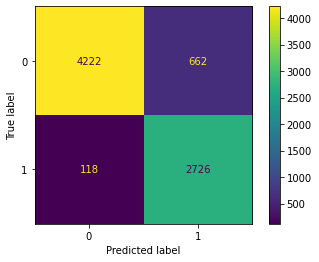

In [ ]:
nb_pred_best = nb_best_model.predict(scaled_X_test)
nb_cm = confusion_matrix(y_test,nb_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=nb_cm)
disp.plot()
plt.show()

In [ ]:
nb_precision, nb_recall, nb_f1_score, nb_accval, nb_aucval = calc_metrics(nb_cm,y_test,nb_pred_best,nb_probtest)
print('Precision :',round(nb_precision,5))
print('Recall    :',round(nb_recall,5))
print('F1-score  :',round(nb_f1_score,5))
print('Accuracy  :',round(nb_accval,5))
print('AUC       :',round(nb_aucval,5))

Precision : 0.8046
Recall    : 0.95851
F1-score  : 0.87484
Accuracy  : 0.89907
AUC       : 0.98557


#LightGBM

In [ ]:
lgbm_params={
     'n_estimators':[50, 150, 200, 250, 300, 350],
     'max_depth':[1, 3, 5, 7, 9]
        }
lgbm_clf = lgb.LGBMClassifier(class_weight='balanced',random_state=0)
lgbm_random = RandomizedSearchCV(lgbm_clf, param_distributions=lgbm_params, 
                              verbose=20, n_jobs=-1, random_state = 0,
                              scoring='roc_auc',cv=5,return_train_score=True)
lgbm_random.fit(scaled_X_train, y_train)
lgbm_probtest = lgbm_random.predict_proba(scaled_X_test)[:,1]
print(lgbm_random.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 200, 'max_depth': 9}


In [ ]:
parameters = lgbm_random.cv_results_['params']
lst=[]
for item in range(len(parameters)):
    lst.append(str(parameters[item]['n_estimators'])+","+str(parameters[item]['max_depth']))

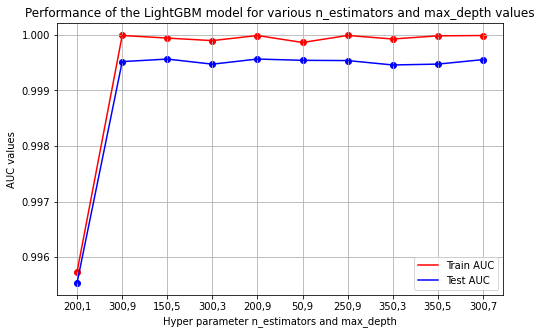

In [ ]:
plt.figure(figsize=(8,5)) 
lgbm_train_auc = lgbm_random.cv_results_['mean_train_score']
lgbm_test_auc  = lgbm_random.cv_results_['mean_test_score']
plt.plot(lst, lgbm_train_auc,color='red',label='Train AUC')
plt.plot(lst, lgbm_test_auc, color='blue', label='Test AUC')
plt.scatter(lst, lgbm_train_auc,color='red')
plt.scatter(lst, lgbm_test_auc,color='blue')
plt.title("Performance of the LightGBM model for various n_estimators and max_depth values")
plt.xlabel("Hyper parameter n_estimators and max_depth")
plt.ylabel("AUC values")
plt.legend()
plt.grid()
plt.show()

In [ ]:
n_estimators = lgbm_random.best_params_['n_estimators']
max_depth = lgbm_random.best_params_['max_depth']
lgbm_best_model = lgb.LGBMClassifier(n_estimators=n_estimators,max_depth=max_depth,
                             class_weight='balanced',random_state=0,first_metric_only = True)
lgbm_best_model.fit(scaled_X_train,y_train,eval_set=[(scaled_X_test,y_test),(scaled_X_train,y_train)],
          verbose=20,eval_metric='auc')

[20]	training's auc: 0.999233	training's binary_logloss: 0.0845241	valid_0's auc: 0.998496	valid_0's binary_logloss: 0.0865922
[40]	training's auc: 0.999752	training's binary_logloss: 0.0209774	valid_0's auc: 0.999198	valid_0's binary_logloss: 0.0237091
[60]	training's auc: 0.999925	training's binary_logloss: 0.00903114	valid_0's auc: 0.999582	valid_0's binary_logloss: 0.013529
[80]	training's auc: 0.999948	training's binary_logloss: 0.00600348	valid_0's auc: 0.999652	valid_0's binary_logloss: 0.0114036
[100]	training's auc: 0.999959	training's binary_logloss: 0.00470788	valid_0's auc: 0.999693	valid_0's binary_logloss: 0.0102926
[120]	training's auc: 0.999974	training's binary_logloss: 0.00387852	valid_0's auc: 0.999731	valid_0's binary_logloss: 0.00941991
[140]	training's auc: 0.999982	training's binary_logloss: 0.00345544	valid_0's auc: 0.999712	valid_0's binary_logloss: 0.00921361
[160]	training's auc: 0.999984	training's binary_logloss: 0.00319057	valid_0's auc: 0.999687	valid_0's

LGBMClassifier(class_weight='balanced', first_metric_only=True, max_depth=9,
               n_estimators=200, random_state=0)

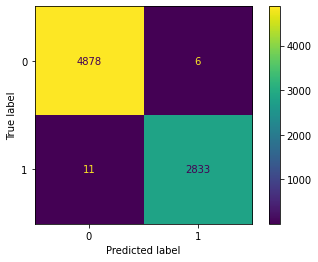

In [ ]:
lgbm_pred_best = lgbm_best_model.predict(scaled_X_test)
lgbm_cm = confusion_matrix(y_test,lgbm_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=lgbm_cm)
disp.plot()
plt.show()

In [ ]:
lgbm_precision, lgbm_recall, lgbm_f1_score, lgbm_accval, lgbm_aucval = calc_metrics(lgbm_cm,y_test,lgbm_pred_best,lgbm_probtest)
print('Precision :',round(lgbm_precision,5))
print('Recall    :',round(lgbm_recall,5))
print('F1-score  :',round(lgbm_f1_score,5))
print('Accuracy  :',round(lgbm_accval,5))
print('AUC       :',round(lgbm_aucval,5))

Precision : 0.99789
Recall    : 0.99613
F1-score  : 0.99701
Accuracy  : 0.9978
AUC       : 0.99967


We can observe that LightGBM model gives best values of performance metrics. 

In [ ]:
myTable = PrettyTable(["Model", "Precision", "Recall", "F1-score", "Accuracy", "AUC"])

myTable.add_row(["LR", "0.84817", "0.95464", "0.89826","0.92042","0.99777"])
myTable.add_row(["SVM", "0.87643", "0.94023", "0.90721", "0.92922", "0.99442"])
myTable.add_row(["Naive Bayes", "0.8046", "0.95851", "0.87484", "0.89907", "0.98557"])
myTable.add_row(["LightGBM", "0.99789", "0.99613", "0.99701", "0.9978", "0.99967"])
print(myTable)

+-------------+-----------+---------+----------+----------+---------+
|    Model    | Precision |  Recall | F1-score | Accuracy |   AUC   |
+-------------+-----------+---------+----------+----------+---------+
|      LR     |  0.84817  | 0.95464 | 0.89826  | 0.92042  | 0.99777 |
|     SVM     |  0.87643  | 0.94023 | 0.90721  | 0.92922  | 0.99442 |
| Naive Bayes |   0.8046  | 0.95851 | 0.87484  | 0.89907  | 0.98557 |
|   LightGBM  |  0.99789  | 0.99613 | 0.99701  |  0.9978  | 0.99967 |
+-------------+-----------+---------+----------+----------+---------+
